In [55]:
from datasets import load_dataset
import torch
import torch.utils as utils
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

In [331]:
# load dataset from huggingface
dataset = load_dataset("mnist")
# documentation:
# https://huggingface.co/docs/datasets/en/loading

dataset['train'][10]["image"]  # way to access train set
dataset['test'][100]["image"] # way to access test set
dataset['train'][10]["label"]  # train label


3

In [281]:
dataset['train'][10]["image"] 

In [58]:
dataset['test'][10]["image"]

In [59]:
dataset['test'][10]["label"]

0

1. We got hold of images/dataset
2. Next, we need convert our data to tensor to work with torch framework
3. One way is to convert data to numpy objects and numpy objects to tensor

In [282]:
# Let's do it for a single image
# convert image to numpy array
image = np.array(dataset['train'][10]["image"])
# numpy array to tensor
image = torch.tensor(image)
# tensor shape
image.shape

torch.Size([28, 28])

In [332]:
# convert dataset to numpy array
train_images = np.array(dataset['train']["image"])
train_labels = np.array(dataset['train']["label"])
test_images = np.array(dataset['test']["image"])
test_labels = np.array(dataset['test']["label"])

# convert numpy array to tensor and also choose the data type
train_images = torch.tensor(train_images, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.int64)
test_images = torch.tensor(test_images, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.int64)

In [333]:
# load tensors to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_images = train_images.to(device)
train_labels = train_labels.to(device)
test_images = test_images.to(device)
test_labels = test_labels.to(device)

Our entire dataset is in tensors, we can now move on to 
to our project!

In [334]:
dataset_test = utils.data.TensorDataset(test_images, test_labels)
dataset_train = utils.data.TensorDataset(train_images, train_labels)

In [335]:
# Task 1.1: Implement a fully connected neural network
# Input layer: 784 neurons
# Hidden layer 1: 1000 neurons
# Output layer: 10 neurons
# Activation function: ReLU
# Number of epochs: 50
# Batch size: 32
# Learning rate: 0.001
# Plot the loss curve
# Calculate the accuracy on the test set
# Print the accuracy on the test set
# return softmax output

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        #self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 1000)
        self.fc2 = nn.Linear(1000, 10)
    def forward(self, x):
        #x = self.flatten(x)
        x = F.sigmoid(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

In [336]:
net=NeuralNetwork().to(device)

In [337]:
def training_fcc(model,batch_size=32):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_loader = utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    loss_list = []
    
    for epoch in range(50):
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs,labels = data
        
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), -1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        loss_list.append(running_loss*batch_size/len(dataset_train))
    torch.save(model.state_dict(), './model_fcc.pth')
    print('Finished Training')
    print('Saved model to ./model_fcc.pth')
    print(loss_list)
    plt.plot(loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

Finished Training
Saved model to ./model_fcc.pth
[1.6142539361953736, 1.563213171895345, 1.5509923047383627, 1.5427072586695354, 1.5376777265548707, 1.535022622235616, 1.5339488556543985, 1.5329042685190837, 1.5302363191604613, 1.5283553667068481, 1.5263427385965984, 1.5246720536549887, 1.524280039469401, 1.5222525232315063, 1.5205992179870604, 1.519090437444051, 1.5177228097279867, 1.517909778658549, 1.517755887858073, 1.5154491119384765, 1.5134186953226725, 1.516402985127767, 1.5150736200968424, 1.5161157881418863, 1.513990968322754, 1.5144135459899903, 1.5147957133611043, 1.5129688319524128, 1.5096365375518799, 1.5106478741327922, 1.510398237101237, 1.5104624519348144, 1.5111602478663126, 1.5124733633041383, 1.5129846335728963, 1.512263552093506, 1.5092088344573975, 1.5133871677398683, 1.5127680816014608, 1.5109079197565713, 1.51021123046875, 1.5093574695587157, 1.5096773511886596, 1.5081923702875772, 1.5074998799006145, 1.5091819134394329, 1.5089051207860311, 1.5098969831466675, 1.

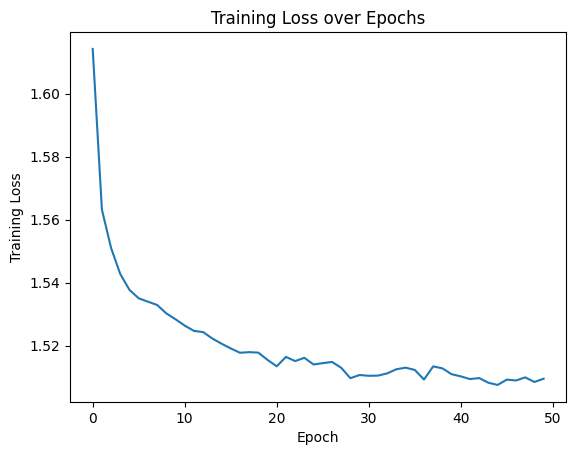

In [338]:
training_fcc(net,32)

In [339]:
# load model from file
net.load_state_dict(torch.load('./model_fcc.pth'))


<All keys matched successfully>

In [340]:
# calculate accuracy on the test set
with torch.no_grad():
    test_loader = utils.data.DataLoader(dataset_test, batch_size=32, shuffle=True)
    correct = 0
    total = 0
    for inputs,labels in test_loader:
        inputs = inputs.view(inputs.shape[0], -1)
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Accuracy of the network on the {total} test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 94 %


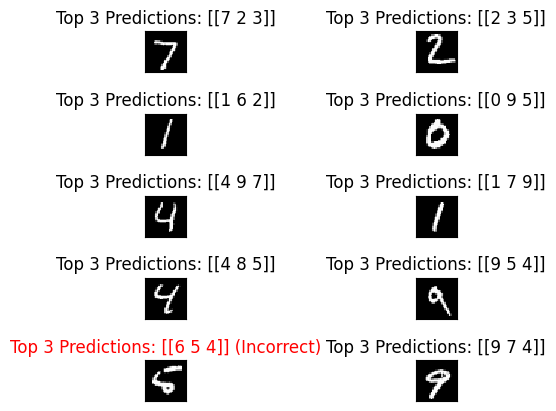

In [91]:
# print top 3 predictions
with torch.no_grad():
    for i in range(10):
        inputs = test_images[i].view(1, -1)
        outputs = net(inputs)
        # show the image
        figure = plt.subplot(5, 2, i + 1)
        plt.subplots_adjust(hspace = 1)

        #figure.subplots_adjust(hspace = 0.4, wspace = 0.4)
        figure.set_title(f'Label: {test_labels[i].cpu().numpy()}')
        _, predicted = torch.topk(outputs, 3, 1)
        
        plt.imshow(inputs.cpu().numpy().reshape(28,28), cmap='gray', interpolation='none', aspect='equal')
        plt.xticks([])
        plt.yticks([])
        if test_labels[i] == predicted.cpu().numpy()[0][0]:
            plt.title(f'Top 3 Predictions: {predicted.cpu().numpy()}')
        else:
            plt.title(f'Top 3 Predictions: {predicted.cpu().numpy()} (Incorrect)', color='red')
        #print(predicted)
        

In [109]:
# Task 1.3: Implement a convolutional neural network
# Convolutional layer 1: 5x5 kernel, 32 filters
# Max pooling layer 1: 2x2 kernel
# Convolutional layer 2: 5x5 kernel, 64 filters
# Max pooling layer 2: 2x2 kernel
# Fully connected layer 1: 1024 neurons
# Fully connected layer 2: 10 neurons
# Activation function: ReLU
# Number of epochs: 50
# Batch size: 32
# Learning rate: 0.001
# Plot the loss curve
# Calculate the accuracy on the test set
# Print the accuracy on the test set
# return softmax output

class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, 3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(676, 1000)
        self.fc2 = nn.Linear(1000, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        #print(x.size())
        x = self.flatten(x)
        #x=F.view(x, x.size(0), -1)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

In [110]:
cnn=ConvolutionalNeuralNetwork().to(device)

In [113]:
def training_cnn(model,batch_size=32):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_loader = utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    test_loader = utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
    loss_list = []
    
    for epoch in range(50):
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs,labels = data
            inputs = inputs.view(inputs.shape[0], 1, 28, 28)
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        loss_list.append(running_loss*batch_size/len(dataset_train))
    torch.save(model.state_dict(), './model_cnn.pth')
    print('Finished Training')
    print('Saved model to ./model_cnn.pth')
    print(loss_list)
    plt.plot(loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

Finished Training
Saved model to ./model_cnn.pth
[1.5149536182403565, 1.5166088718414306, 1.515305063120524, 1.5132280659357706, 1.513323498916626, 1.5126344374338785, 1.5129379102071125, 1.5120160906473796, 1.512593011411031, 1.508986222775777, 1.5105466694513956, 1.5109063580830893, 1.5104110524495442, 1.5082438092549642, 1.5086610187530518, 1.5088484972000122, 1.5084967555363973, 1.5058943840662637, 1.5064190881093342, 1.5067340514500935, 1.5063271892547607, 1.5082875833511353, 1.5065149537404379, 1.5058401903788248, 1.5043187125523885, 1.5044613246917724, 1.5050529443105063, 1.5053124209721882, 1.5052837933858236, 1.5051711438496909, 1.5044852474212647, 1.5075688132603964, 1.5076884208043417, 1.5071025941212972, 1.5052105207443238, 1.5061846309026083, 1.5073739978154501, 1.506243286450704, 1.5059734300613403, 1.5057594833374024, 1.504832286453247, 1.5044974060058594, 1.5059079902013144, 1.5060005099614462, 1.507476910463969, 1.5067157529830932, 1.505352343559265, 1.5058118578592936

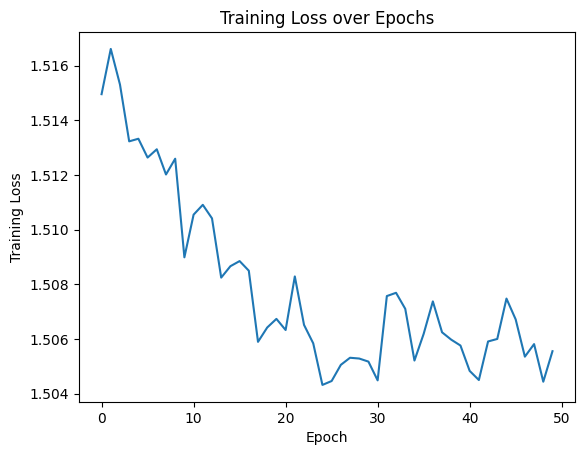

In [114]:
training_cnn(cnn)

In [115]:
# load model from file
cnn.load_state_dict(torch.load('./model_cnn.pth'))


<All keys matched successfully>

In [116]:
# calculate accuracy on the test set

with torch.no_grad():
    test_loader = utils.data.DataLoader(dataset_test, batch_size=32, shuffle=True)
    correct = 0
    total = 0
    for inputs,labels in test_loader:
        inputs = inputs.view(inputs.shape[0], 1, 28, 28)
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = cnn(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Accuracy of the network on the {total} test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 95 %


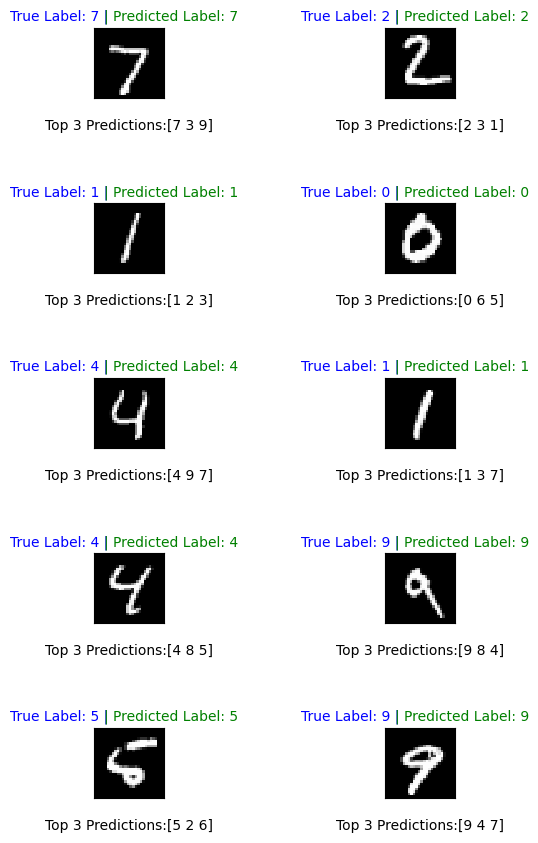

In [302]:
# print top 3 predictions
# print top 3 predictions
plt.figure(figsize=(5, 10))

with torch.no_grad():
    for i in range(10):
        inputs = test_images[i].view(1, 1, 28, 28)
        outputs = cnn(inputs)
        # show the image
        figure = plt.subplot(5, 2, i + 1)
        plt.subplots_adjust(hspace = 1.5, wspace = 2)

        
        #figure.set_title(f'True Label: {test_labels[i].cpu().numpy()}, Predicted Label: {torch.argmax(outputs).cpu().numpy()}',color='blue')
        figure.text(-.5, 1.05, f"True Label: {test_labels[i].cpu().numpy()} |", ha='center', va='bottom', color='blue', transform=figure.transAxes)
        figure.text(1.1, 1.05,  f"| Predicted Label: {torch.argmax(outputs).cpu().numpy()}", ha='center', va='bottom', color='green', transform=figure.transAxes)
        _, predicted = torch.topk(outputs, 3, 1)
        
        plt.imshow(inputs.cpu().numpy().reshape(28,28), cmap='gray', interpolation='none', aspect='equal')
        plt.xticks([])
        plt.yticks([])
        if test_labels[i] == predicted.cpu().numpy()[0][0]:
            #plt.text(0.5, .4, "Top 3 Predictions: ", ha='center', va='bottom', fontsize=12, transform=plt.gca().transAxes)
            plt.figtext(.5, -.5, 'Top 3 Predictions:'+str(predicted[0][0:3].cpu().numpy()), ha='center', va='bottom', fontsize=10, transform=plt.gca().transAxes)
        else:
            plt.figtext(.5, -.5, 'Top 3 Predictions:'+str(predicted[0][0:3].cpu().numpy()), ha='center', va='bottom', fontsize=10, color='red', transform=plt.gca().transAxes)
        #print(predicted)


Task 1.3 Permuted images

Let's look how to permute image

(-0.5, 27.5, 27.5, -0.5)

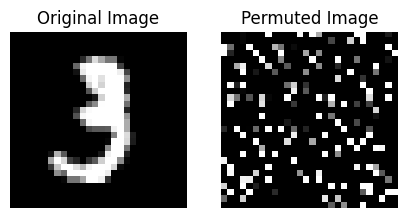

In [297]:
# randomly permute flattened image
# permute a 28x28 image
# fix the seed
torch.manual_seed(0)
image = np.array(dataset['train'][10]["image"])
image = torch.tensor(image)
image = image.view(-1)
permuted_image = torch.randperm(image.numel())
permuted_image = image[permuted_image]
permuted_image = permuted_image.view(28, 28)

# plot the original and permuted image
plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.view(28, 28), cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(permuted_image, cmap='gray')
plt.title('Permuted Image')
plt.axis('off')

Remember two things:
1. Fix the seed before permuting the image.
2. Don't create a new permutation for each image. 

Create a single permutation and use it for all images.

In [286]:
# permute every image in the dataset
# fix the seed
torch.manual_seed(0)
perm=torch.randperm(784) # set to 784 for 28x28 image
# don't create a new permutation for every image
# create a single permutation and use it for all images
def permute_dataset(image_dataset):
    
    perm_dataset=torch.empty_like(image_dataset)
    for i in range(len(image_dataset)):
        #print(image_dataset.shape)
        image = image_dataset[i]
        #print(image.shape)
        image = image.view(-1)
        #print(image.shape)
        perm_dataset[i] = image.view(-1)[perm].view(28, 28)
    return perm_dataset


In [287]:
permuted_train_images=permute_dataset(train_images[0:10])


(-0.5, 27.5, 27.5, -0.5)

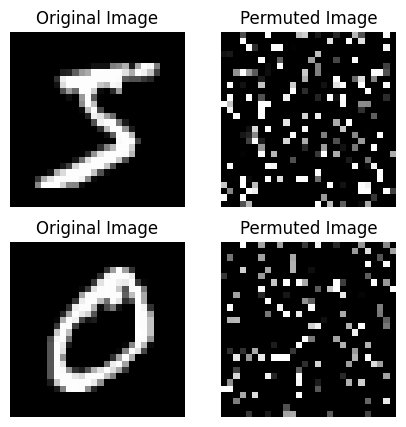

In [322]:
# plot the original and permuted image
plt.figure(figsize=(5, 5))
plt.subplot(2, 2, 1)
plt.imshow(train_images[0].view(28, 28).to('cpu'), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(permuted_train_images[0].to('cpu'), cmap='gray')
plt.title('Permuted Image')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(train_images[1].view(28, 28).to('cpu'), cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(permuted_train_images[2].to('cpu'), cmap='gray')
plt.title('Permuted Image')
plt.axis('off')

In [295]:
permuted_train_images = permute_dataset(train_images)
# load permuted dataset to device
permuted_train_images = permuted_train_images.to(device)

In [296]:
permuted_test_images = permute_dataset(test_images)
# load permuted dataset to device
permuted_test_images = permuted_test_images.to(device)

In [317]:
permuted_dataset_test = utils.data.TensorDataset(permuted_test_images, test_labels)
permuted_dataset_train = utils.data.TensorDataset(permuted_train_images, train_labels)

In [341]:
def training_fcc_perm(model,batch_size=32):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_loader = utils.data.DataLoader(permuted_dataset_train, batch_size=batch_size, shuffle=True)
    loss_list = []
    
    for epoch in range(50):
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs,labels = data
        
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), -1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        loss_list.append(running_loss*batch_size/len(permuted_dataset_train))
    torch.save(model.state_dict(), './model_fcc_perm.pth')
    print('Finished Training')
    print('Saved model to ./model_fcc_perm.pth')
    print(loss_list)
    plt.plot(loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

Finished Training
Saved model to ./model_fcc_perm.pth
[2.0028513566970827, 1.9132026355107625, 1.9008089955012004, 1.8678038490931193, 1.8009252272923788, 1.7959657152175903, 1.7959178126017252, 1.7939898224512736, 1.7917625268300374, 1.790292526181539, 1.788817081197103, 1.7872902545293172, 1.785114195505778, 1.7854007184346516, 1.7855090432484946, 1.7822070141474406, 1.7818620344161988, 1.7812006251653036, 1.7802360345840453, 1.779779728571574, 1.7811084929148355, 1.7793715564727783, 1.7793202975591025, 1.7800663243611654, 1.7772473756154379, 1.7783915115992228, 1.7796791124979654, 1.7781688417434693, 1.778112584877014, 1.7787348892847696, 1.7785401889801025, 1.7786747080485026, 1.777276650238037, 1.7753451000849405, 1.7761705204645792, 1.7749910217285156, 1.7748498945236206, 1.7748527751286824, 1.7753487607955933, 1.775487935256958, 1.7758358392715454, 1.7760105827331543, 1.7751782367070517, 1.774307524617513, 1.7726158908843994, 1.7735659123738607, 1.772176544380188, 1.773118388811

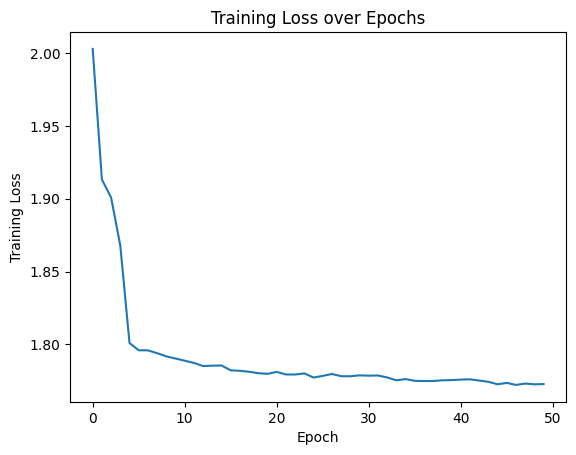

In [342]:
training_fcc_perm(net,32)

In [345]:
net.load_state_dict(torch.load('./model_fcc_perm.pth'))


<All keys matched successfully>

In [346]:
# calculate accuracy on the test set
with torch.no_grad():
    test_loader = utils.data.DataLoader(permuted_dataset_test, batch_size=32, shuffle=True)
    correct = 0
    total = 0
    for inputs,labels in test_loader:
        inputs = inputs.view(inputs.shape[0], -1)
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Accuracy of the network on the {total} test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 67 %


On original dataset our network performance to 94%

On permuted dataset our network performance to  67%

In [348]:
# Training CNN on permuted dataset
def training_cnn_perm(model,batch_size=32):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_loader = utils.data.DataLoader(permuted_dataset_train, batch_size=batch_size, shuffle=True)
    
    loss_list = []
    
    for epoch in range(50):
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs,labels = data
            inputs = inputs.view(inputs.shape[0], 1, 28, 28)
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        loss_list.append(running_loss*batch_size/len(permuted_dataset_train))
    torch.save(model.state_dict(), './model_cnn_perm.pth')
    print('Finished Training')
    print('Saved model to ./model_cnn_perm.pth')
    print(loss_list)
    plt.plot(loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss over Epochs')
    plt.show()


Finished Training
Saved model to ./model_cnn_perm.pth
[2.178499458503723, 2.1165352190653484, 2.0079326657613117, 1.9943575654347738, 1.9911326325098673, 1.9199996089935303, 1.8985808331807454, 1.8957473730723062, 1.8945710715611777, 1.891834994316101, 1.8750595752716064, 1.8018494223276773, 1.7973251571655273, 1.796181696065267, 1.7923810302734375, 1.7929285022735595, 1.7915304141998292, 1.7915450424194337, 1.7893509889602661, 1.7910916756947834, 1.7908875988006592, 1.7910968136469523, 1.794266664059957, 1.7900827847798666, 1.7907166460673014, 1.7898624780019123, 1.7883772289911906, 1.7858029148101806, 1.7851313899358114, 1.7854913785298665, 1.7859112858454387, 1.7860718325297038, 1.7871925311406454, 1.7854594884236654, 1.7859192384084066, 1.7839705657958984, 1.784384779294332, 1.7849400833765665, 1.7841324061075847, 1.7852091926574707, 1.7835142669041952, 1.7852400299708049, 1.7846972344080607, 1.7848668341318765, 1.7859709043502807, 1.7865933557510376, 1.7851106890996298, 1.78320416

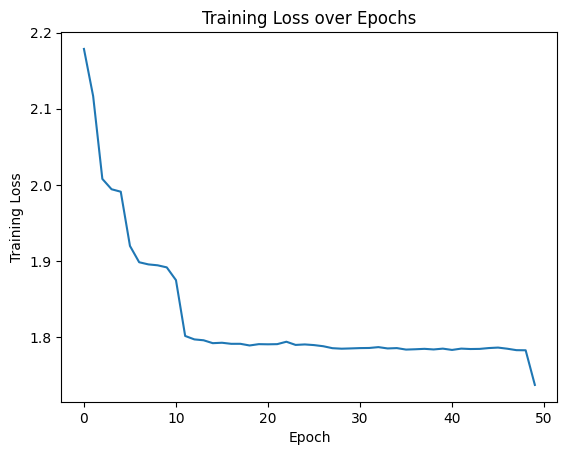

In [349]:
training_cnn_perm(cnn)

In [350]:
# load model from file
cnn.load_state_dict(torch.load('./model_cnn_perm.pth'))

<All keys matched successfully>

In [351]:
# calculate accuracy on the test set
with torch.no_grad():
    test_loader = utils.data.DataLoader(permuted_dataset_test, batch_size=32, shuffle=True)
    correct = 0
    total = 0
    for inputs,labels in test_loader:
        inputs = inputs.view(inputs.shape[0], 1, 28, 28)
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = cnn(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Accuracy of the network on the {total} test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 75 %
